# Entity Resolution project @ Wavestone
## Blocking with sentence embeddings

> **Tristan PERROT**


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os

import torch

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:1


In [2]:
while 'model' not in os.listdir():
    os.chdir('..')

In [3]:
from model.utils import load_data

In [4]:
MODEL_NAME = ''
DATA_NAME = 'amazon-google'
COMPUTER = 'gpu4.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

In [5]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR, remove_col_names=True, order_cols=False)
table_a_serialized[:5]

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



['clickart 950 000 - premier image pack (dvd-rom)  broderbund 0.0',
 "noah's ark activity center (jewel case ages 3-8)  victory multimedia 0.0",
 "peachtree by sage premium accounting for nonprofits 2007 peachtree premium accounting for nonprofits 2007 is the affordable easy to use accounting solution that provides you with donor/grantor management. if you're like most nonprofit organizations you're constantly striving to maximize each and every dollar of your annual operating budget. financial reporting by programs and funds advanced operational reporting and the rock-solid core accounting features that have made peachtree the choice of hundreds of thousands of small businesses. the result is an accounting solution tailor-made for the challenges of operating a nonprofit organization. keep an audit trail to record and report on any changes made to your transactions improve data integrity with prior period locking archive your organization's data for snap shots of your data before you c

In [6]:
all_true_matches = set()
for i in range(len(X_train_ids)):
    if y_train[i] == 1:
        all_true_matches.add((X_train_ids[i][0], X_train_ids[i][1]))
for i in range(len(X_valid_ids)):
    if y_valid[i] == 1:
        all_true_matches.add((X_valid_ids[i][0], X_valid_ids[i][1]))
for i in range(len(X_test_ids)):
    if y_test[i] == 1:
        all_true_matches.add((X_test_ids[i][0], X_test_ids[i][1]))

## Pre-processing

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm, trange

In [8]:
MODEL_NAMES = [
    'sentence-transformers/allenai-specter',
    'all-distilroberta-v1',
    'all-mpnet-base-v2',
    'multi-qa-mpnet-base-dot-v1',
]

In [ ]:
def perform_blocking_sbert(model_name, table_a_serialized, table_b_serialized, n_neighbors=20, metric='cosine', device='cpu'):
    model = SentenceTransformer(model_name, device=device)
    table_a_embeddings = model.encode(table_a_serialized)
    table_b_embeddings = model.encode(table_b_serialized)

    knn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    knn.fit(table_b_embeddings)

    return knn.kneighbors(table_a_embeddings, return_distance=False)

def get_blocking_metrics(indices, all_true_matches, len_table_a, len_table_b):
    n_m = len(all_true_matches)
    n_n = len_table_a * len_table_b - n_m
    s_m = 0
    s_n = 0

    for i in range(len(indices)):
        for j in indices[i]:
            if (i, j) in all_true_matches:
                s_m += 1
            else:
                s_n += 1
    
    reduction_ratio = 1 - (s_m + s_n) / (n_m + n_n)
    recall = s_m / n_m
    f1 = 2 * (reduction_ratio * recall) / (reduction_ratio + recall)

    return reduction_ratio, recall, f1

def perform_blocking_tfidf(table_a_serialized, table_b_serialized, n_neighbors=20, metric='cosine'):
    vectorizer = TfidfVectorizer()
    table_a_tfidf = vectorizer.fit_transform(table_a_serialized)
    table_b_tfidf = vectorizer.transform(table_b_serialized)

    knn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    knn.fit(table_b_tfidf)

    return knn.kneighbors(table_a_tfidf, return_distance=False)

def merge_indices(indices1, indices2):
    merged_indices = []
    assert len(indices1) == len(indices2)
    for i in range(len(indices1)):
        merged_indices.append(list(set(indices1[i]) | set(indices2[i])))
    return merged_indices

## Training

### KNN

In [ ]:
list_f1_scores_vs_n_neighbors = []
k_s = list(range(1,30))

for model_name in MODEL_NAMES:
    print(f'Performing blocking with model {model_name}...')
    f1_scores_vs_n_neighbors = []
    for k in tqdm(k_s, desc=f'K neighbors for model {model_name}...'):
        indices = perform_blocking_sbert(model_name, table_a_serialized, table_b_serialized, n_neighbors=k, device=device)
        reduction_ratio, recall, f1 = get_blocking_metrics(indices, all_true_matches, len(table_a_serialized), len(table_b_serialized))
        f1_scores_vs_n_neighbors.append(f1)
    list_f1_scores_vs_n_neighbors.append(f1_scores_vs_n_neighbors)

Performing blocking with model sentence-transformers/allenai-specter...


K neighbors for model sentence-transformers/allenai-specter...:   0%|          | 0/29 [00:00<?, ?it/s]

Performing blocking with model all-distilroberta-v1...


K neighbors for model all-distilroberta-v1...:   0%|          | 0/29 [00:00<?, ?it/s]

Performing blocking with model all-mpnet-base-v2...


K neighbors for model all-mpnet-base-v2...:   0%|          | 0/29 [00:00<?, ?it/s]

Performing blocking with model multi-qa-mpnet-base-dot-v1...


K neighbors for model multi-qa-mpnet-base-dot-v1...:   0%|          | 0/29 [00:00<?, ?it/s]

Performing blocking with TF-IDF...:   0%|          | 0/29 [00:00<?, ?it/s]

TypeError: unhashable type: 'numpy.ndarray'

In [22]:
tfidf_f1_scores_vs_n_neighbors = []
for k in tqdm(k_s, desc='Performing blocking with TF-IDF...'):
    tfidif_indices = perform_blocking_tfidf(table_a_serialized, table_b_serialized, n_neighbors=k)
    reduction_ratio, recall, f1 = get_blocking_metrics(tfidif_indices, all_true_matches, len(table_a_serialized), len(table_b_serialized))
    tfidf_f1_scores_vs_n_neighbors.append(f1)
list_f1_scores_vs_n_neighbors.append(tfidf_f1_scores_vs_n_neighbors)

Performing blocking with TF-IDF...:   0%|          | 0/29 [00:00<?, ?it/s]

In [50]:
# TF-IDF merged with best SBERT model
merged_f1_scores_vs_n_neighbors = []
for k in tqdm(k_s, desc='Merging SBERT and TF-IDF...'):
    sbert_indices = perform_blocking_sbert(MODEL_NAMES[-1], table_a_serialized, table_b_serialized, n_neighbors=k, device=device)
    tfidf_indices = perform_blocking_tfidf(table_a_serialized, table_b_serialized, n_neighbors=k)
    merged_indices = merge_indices(sbert_indices, tfidf_indices)
    reduction_ratio, recall, f1 = get_blocking_metrics(merged_indices, all_true_matches, len(table_a_serialized), len(table_b_serialized))
    merged_f1_scores_vs_n_neighbors.append(f1)

Merging SBERT and TF-IDF...:   0%|          | 0/29 [00:00<?, ?it/s]

#### Plot

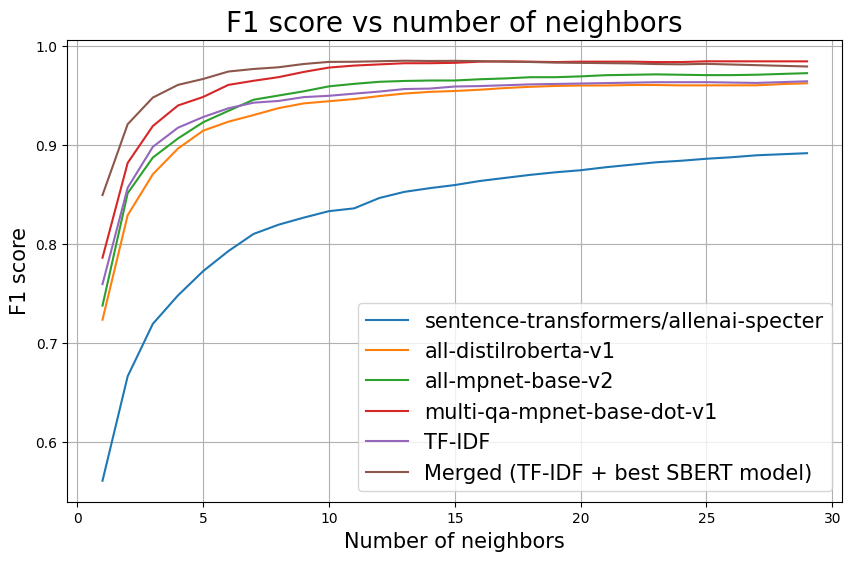

In [61]:
plt.figure(figsize=(10, 6))
for i, model_name in enumerate(MODEL_NAMES):
    plt.plot(k_s, list_f1_scores_vs_n_neighbors[i], label=model_name)
plt.plot(k_s, tfidf_f1_scores_vs_n_neighbors, label='TF-IDF')
plt.plot(k_s, merged_f1_scores_vs_n_neighbors, label='Merged (TF-IDF + best SBERT model)')
plt.xlabel('Number of neighbors', fontsize=15)
plt.ylabel('F1 score', fontsize=15)
plt.title('F1 score vs number of neighbors', fontsize=20)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()